In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from IPython.core.display_functions import display

import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.segmentation as seg

from biogeme.expressions import Beta, Variable, log, exp
from biogeme.results import compile_estimation_results
from biogeme.models import loglogit, boxcox


# Mathematical Modelling of Behaviour - Group Project

**Group 9**

*Julien Marie F Ars, Chady Bensaid, Mohamed Amine Lazrak, Joshua Oyewole Oyebanji*

## 0. Initialisation

First, we import the data and input it in a python database

In [3]:
df = pd.read_csv("data/lpmc09.dat", sep="\t")
df

,trip_id,household_id,person_n,trip_n,travel_mode,purpose,fueltype,faretype,bus_scale,survey_year,...,dur_pt_access,dur_pt_rail,dur_pt_bus,dur_pt_int,pt_interchanges,dur_driving,cost_transit,cost_driving_fuel,cost_driving_ccharge,driving_traffic_percent
0,4,0,1,2,4,3,1,4,1.0,1,...,0.203056,0.000000,0.189444,0.000000,0,0.229167,1.50,0.78,0.0,0.130909
1,30,8,1,3,1,3,1,1,1.0,1,...,0.098889,0.000000,0.044444,0.000000,0,0.087500,1.50,0.20,0.0,0.292064
2,38,9,1,1,4,3,1,3,0.0,1,...,0.194722,0.000000,0.107778,0.000000,0,0.207778,0.00,0.49,0.0,0.467914
3,49,12,0,3,4,3,1,5,0.0,1,...,0.082500,0.000000,0.061944,0.000000,0,0.062500,0.00,0.20,0.0,0.124444
4,102,20,2,0,2,3,1,1,1.0,1,...,0.339722,0.183333,0.116667,0.266667,1,0.250833,3.00,0.89,0.0,0.170543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,81046,17605,0,2,3,3,1,5,0.0,3,...,0.160000,0.000000,0.391667,0.069722,1,0.314444,0.00,0.83,10.5,0.468198
4996,81048,17605,0,4,4,3,1,5,0.0,3,...,0.248056,0.000000,0.220833,0.000000,0,0.206667,0.00,0.55,0.0,0.205645
4997,81064,17608,0,0,3,1,6,1,1.0,3,...,0.123333,0.083333,0.116667,0.183333,2,0.374722,4.40,0.83,10.5,0.835434
4998,81067,17609,0,0,4,3,1,1,1.0,3,...,0.090278,0.000000,0.116667,0.000000,0,0.142500,1.50,0.42,0.0,0.087719


In [4]:
database = db.Database("london_passenger_mode_choice", df)

Let's explore a bit more the availlable columns, and create `Variable` instances at the same time :

In [5]:
for c in df.columns:
    print(c, df[c].count(), df[c].mean(), df[c].min(), df[c].max(), len(df[c].unique()))
    globals()[c] = Variable(c)

trip_id 5000 40862.7946 4 81079 5000
household_id 5000 8779.049 0 17613 4155
person_n 5000 0.8154 0 7 8
trip_n 5000 1.5228 0 15 15
travel_mode 5000 3.0344 1 4 4
purpose 5000 2.9076 1 5 5
fueltype 5000 2.8352 1 6 6
faretype 5000 2.2494 1 5 5
bus_scale 5000 0.6456 0.0 1.0 3
survey_year 5000 1.9922 1 3 3
travel_year 5000 2013.1904 2012 2015 4
travel_month 5000 6.7214 1 12 12
travel_date 5000 15.3074 1 31 31
day_of_week 5000 3.9066 1 7 7
start_time 5000 13.714623333305802 0.0 23.91666667 415
age 5000 39.4466 5 93 88
female 5000 0.5246 0 1 2
driving_license 5000 0.6178 0 1 2
car_ownership 5000 0.9784 0 2 3
distance 5000 4563.3578 99 32918 3661
dur_walking 5000 1.1194776666612 0.028611111 7.688333332999999 3656
dur_cycling 5000 0.3589819444438 0.0072222219999999 2.315 2375
dur_pt_access 5000 0.1600849444384 0.0 0.7605555559999999 1255
dur_pt_rail 5000 0.087053333335 0.0 1.116666667 64
dur_pt_bus 5000 0.1740006666632 0.0 1.65 1531
dur_pt_int 5000 0.044296333333999995 0.0 0.541388889 346
pt_in

Now, we compute the total travel time for public transport (`pt`) and the total driving cost.

In [6]:
dur_pt = dur_pt_rail + dur_pt_int + dur_pt_bus +  dur_pt_access
cost_driving = cost_driving_ccharge + cost_driving_fuel
print(dur_pt, cost_driving)


(((dur_pt_rail + dur_pt_int) + dur_pt_bus) + dur_pt_access) (cost_driving_ccharge + cost_driving_fuel)


We need also to check whether the `car_ownership` and `driving_license` variables are availlability conditions :

In [7]:
df[((df["travel_mode"] == 4) & (df["driving_license"] == 0) & (df["car_ownership"] == 0))][["travel_mode", "driving_license", "car_ownership"]]

,travel_mode,driving_license,car_ownership
44,4,0,0
103,4,0,0
169,4,0,0
295,4,0,0
296,4,0,0
...,...,...,...
4509,4,0,0
4675,4,0,0
4755,4,0,0
4847,4,0,0


Since there are people that still choose to go by driving whithout owning a car or holding a driving license, the variables are not considered to be availlability conditions

## 1. Model #0 : Generic model

We define our first model as :
$$ V_{pt} = \beta_{pt} + \beta_{cost} * \mathrm{cost\_transit} + \beta_{time} *  \mathrm{dur\_pt}$$
$$ V_{driving} = \beta_{driving} + \beta_{cost} *  \mathrm{cost\_driving} + \beta_{time} *  \mathrm{dur\_driving}$$
$$ V_{cycling} = \beta_{cycling} + \beta_{time} *  \mathrm{dur\_cycling} $$
$$ V_{walking} = \beta_{time} *  \mathrm{dur\_walking}$$

In [8]:
asc_pt = Beta("asc_pt", 0, None, None, 0)
asc_driving = Beta("asc_driving", 0, None, None, 0)
asc_cycling = Beta("asc_cycling", 0, None, None, 0)

beta_cost = Beta("beta_cost", 0, None, None, 0)
beta_time = Beta("beta_time", 0, None, None, 0)

V_pt = asc_pt + beta_cost * cost_transit + beta_time * dur_pt
V_driving = asc_driving + beta_cost * cost_driving + beta_time * dur_driving
V_cycling = asc_cycling + beta_time * dur_cycling
V_walking = beta_time * dur_walking # Note that asc_walking has been fixed to 0

V = {
    1: V_walking,
    2: V_cycling,
    3: V_pt,
    4 : V_driving
}

logprob = loglogit(V, av=None, i=travel_mode)

biogeme_0 = bio.BIOGEME(database, logprob)
biogeme_0.modelName = "MODEL_0"

results_0 = biogeme_0.estimate()
print(results_0.print_general_statistics())
results_0.get_estimated_parameters()

Number of estimated parameters:	5
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4689.119
Final log likelihood:	-4689.119
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00107
Akaike Information Criterion:	9388.238
Bayesian Information Criterion:	9420.824
Final gradient norm:	6.6496E-04
Nbr of threads:	8



,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-3.794242,0.106195,-35.729152,0.0
asc_driving,-1.244754,0.078746,-15.807208,0.0
asc_pt,-0.529325,0.053172,-9.955005,0.0
beta_cost,-0.156193,0.013416,-11.642401,0.0
beta_time,-5.080437,0.195095,-26.040781,0.0


## 2. Model #1 : Specification on the time attribute

We change the time parameter to be alternative-specific. We choose time as cost only covers 2 alternatives, and there could be a logical explanation (Mr. B prefer to spend time in the train as he can work during that time)

In [9]:
beta_time_walking = Beta("beta_time_walking", 0, None, None, 0)
beta_time_cycling = Beta("beta_time_cycling", 0, None, None, 0)
beta_time_pt = Beta("beta_time_pt", 0, None, None, 0)
beta_time_driving = Beta("beta_time_driving", 0, None, None, 0)

V_pt = asc_pt + beta_cost * cost_transit + beta_time_pt * dur_pt
V_driving = asc_driving + beta_cost * cost_driving + beta_time_driving * dur_driving
V_cycling = asc_cycling + beta_time_cycling * dur_cycling
V_walking = beta_time_walking * dur_walking # Note that asc_walking has been fixed to 0

V = {
    1: V_walking,
    2: V_cycling,
    3: V_pt,
    4 : V_driving
}

logprob = loglogit(V, av=None, i=travel_mode)

biogeme_1 = bio.BIOGEME(database, logprob)
biogeme_1.modelName = "MODEL_1"

results_1 = biogeme_1.estimate()
print(results_1.print_general_statistics())
results_1.get_estimated_parameters()

Number of estimated parameters:	8
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4391.665
Final log likelihood:	-4391.665
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00182
Akaike Information Criterion:	8799.331
Bayesian Information Criterion:	8851.468
Final gradient norm:	5.7744E-04
Nbr of threads:	8



,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.537253,0.191134,-23.738561,0.0
asc_driving,-1.868671,0.128616,-14.529054,0.0
asc_pt,-2.298942,0.128518,-17.888030,0.0
beta_cost,-0.145771,0.014601,-9.983547,0.0
beta_time_cycling,-5.209436,0.448206,-11.622864,0.0
beta_time_driving,-5.661297,0.372514,-15.197550,0.0
beta_time_pt,-2.979525,0.236053,-12.622295,0.0
beta_time_walking,-7.626763,0.381250,-20.004637,0.0


We compare both results :

In [10]:
compile_estimation_results({"Model #0": results_0, "Model #1": results_1})

(                                       Model #0         Model #1
 Number of estimated parameters                5                8
 Sample size                                5000             5000
 Final log likelihood                -4689.11913     -4391.665442
 Akaike Information Criterion         9388.23826      8799.330884
 Bayesian Information Criterion      9420.824226      8851.468429
 asc_cycling (t-test)             -3.79  (-35.7)   -4.54  (-23.7)
 asc_driving (t-test)             -1.24  (-15.8)   -1.87  (-14.5)
 asc_pt (t-test)                 -0.529  (-9.96)    -2.3  (-17.9)
 beta_cost (t-test)              -0.156  (-11.6)  -0.146  (-9.98)
 beta_time (t-test)                 -5.08  (-26)                 
 beta_time_cycling (t-test)                        -5.21  (-11.6)
 beta_time_driving (t-test)                        -5.66  (-15.2)
 beta_time_pt (t-test)                             -2.98  (-12.6)
 beta_time_walking (t-test)                          -7.63  (-20),
 {'Model 

**Statistical testing**

From the lesson, we know that the statistic $-2 \left ( \mathcal{L}_0 - \mathcal{L}_1 \right ) \sim \chi_d$, with $d$ the difference in model parameters : $d= 8 - 5 = 3$. This is a valid usage of the statistic test, as it is possible to go from model 1 to model 0 by a linear restriction : $\beta_{time, i} = \beta_{time} \forall i$

In [11]:
results_1.likelihood_ratio_test(results_0)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=594.9073763012548, threshold=np.float64(7.814727903251179))

Given the result (rejection of the null hypothesis, that is that the base model is the 'real' model), we keep model 1 as the prefered model going further

In [12]:
results_pref = results_1

## 3. Model #2 : Add a socioeconomic characteristic (Gender)

We will add a socioeconomic characteristic, gender, and take it into account. The assumption is that individuals of different gender will give a different value to time and to mode choices.

In [13]:
gender_seg = seg.DiscreteSegmentationTuple(
    variable=female,
    mapping = {
        0 : "male",
        1 : "female"
    }   
)

### Model #2a : ASC gender segmentation

In [14]:
seg_asc_cycling = seg.Segmentation(asc_cycling, [gender_seg]).segmented_beta()
seg_asc_pt = seg.Segmentation(asc_pt, [gender_seg]).segmented_beta()
seg_asc_driving = seg.Segmentation(asc_driving, [gender_seg]).segmented_beta()

V_pt = seg_asc_pt + beta_cost * cost_transit + beta_time_pt * dur_pt
V_driving = seg_asc_driving + beta_cost * cost_driving + beta_time_driving * dur_driving
V_cycling = seg_asc_cycling + beta_time_cycling * dur_cycling
V_walking = beta_time_walking * dur_walking # Note that asc_walking has been fixed to 0

V = {
    1: V_walking,
    2: V_cycling,
    3: V_pt,
    4 : V_driving
}

logprob = loglogit(V, av=None, i=travel_mode)

biogeme_2a = bio.BIOGEME(database, logprob)
biogeme_2a.modelName = "MODEL_2a"

results_2a = biogeme_2a.estimate()
print(results_2a.print_general_statistics())
results_2a.get_estimated_parameters()

Number of estimated parameters:	11
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4375.987
Final log likelihood:	-4375.987
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00251
Akaike Information Criterion:	8773.973
Bayesian Information Criterion:	8845.662
Final gradient norm:	1.3116E-03
Nbr of threads:	8



,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.157286,0.207682,-20.017531,0.000000
asc_cycling_female,-0.804924,0.197081,-4.084232,0.000044
asc_driving,-1.915548,0.139078,-13.773181,0.000000
asc_driving_female,0.079161,0.093195,0.849411,0.395653
asc_pt,-2.410304,0.139826,-17.237881,0.000000
asc_pt_female,0.188745,0.097757,1.930750,0.053514
beta_cost,-0.145613,0.014599,-9.974062,0.000000
beta_time_cycling,-5.400175,0.458149,-11.786940,0.000000
beta_time_driving,-5.683096,0.373592,-15.212038,0.000000
beta_time_pt,-2.978588,0.236756,-12.580832,0.000000


We perform a likelihood ratio test, as again `model_pref` (`model_1`in our case) is a reduction of `model_2a`

In [15]:
results_2a.likelihood_ratio_test(results_pref)

LRTuple(message='H0 can be rejected at level 5.0%', statistic=31.357706830853203, threshold=np.float64(7.814727903251179))

### Model #2b : $\beta_{cost}$ gender segmentation

In [16]:
seg_beta_cost = seg.Segmentation(beta_cost, [gender_seg]).segmented_beta()

V_pt = asc_pt + seg_beta_cost * cost_transit + beta_time_pt * dur_pt
V_driving = asc_driving + seg_beta_cost * cost_driving + beta_time_driving * dur_driving
V_cycling = asc_cycling + beta_time_cycling * dur_cycling
V_walking = beta_time_walking * dur_walking # Note that asc_walking has been fixed to 0

V = {
    1: V_walking,
    2: V_cycling,
    3: V_pt,
    4 : V_driving
}

logprob = loglogit(V, av=None, i=travel_mode)

biogeme_2b = bio.BIOGEME(database, logprob)
biogeme_2b.modelName = "MODEL_2b"

results_2b = biogeme_2b.estimate()
print(results_2b.print_general_statistics())
results_2b.get_estimated_parameters()

Number of estimated parameters:	9
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4391.598
Final log likelihood:	-4391.598
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00205
Akaike Information Criterion:	8801.195
Bayesian Information Criterion:	8859.85
Final gradient norm:	4.1187E-01
Nbr of threads:	8



,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.537751,0.191198,-23.733196,0.000000e+00
asc_driving,-1.868633,0.128615,-14.528897,0.000000e+00
asc_pt,-2.298191,0.128511,-17.883200,0.000000e+00
beta_cost,-0.141036,0.021005,-6.714450,1.887757e-11
beta_cost_female,-0.009976,0.027356,-0.364684,7.153470e-01
beta_time_cycling,-5.206131,0.448637,-11.604341,0.000000e+00
beta_time_driving,-5.658758,0.372996,-15.171080,0.000000e+00
beta_time_pt,-2.978971,0.236100,-12.617438,0.000000e+00
beta_time_walking,-7.626485,0.381275,-20.002571,0.000000e+00


We perform a likelihood ratio test, as again `model_pref` (`model_1`in our case) is a reduction of `model_2b`

In [17]:
results_2b.likelihood_ratio_test(results_pref)

LRTuple(message='H0 cannot be rejected at level 5.0%', statistic=0.13563597219035728, threshold=np.float64(3.841458820694124))

We can see that `model_2b` fail the hypothetical test, and we keep `model_2a`

In [18]:
results_pref = results_2a

## Model #3 : Non-Linear transformation of one of the variables

We want to add a non-linear transformation on the variable `beta_cost`.

In order to take into account that indiviuals might value differently a same difference in cost (i.e. between 120 CHF and 125 CHF vs between 10 CHF and 15 CHF), we transform the variable using a Box-Cox transforms :

In [23]:
lambda_boxcox = Beta('lambda_boxcox', 1, -10, 10, 0)
boxcox_cost_tp = boxcox(cost_transit, lambda_boxcox)
boxcox_cost_driving = boxcox(cost_driving, lambda_boxcox)

V_pt = seg_asc_pt + beta_cost * boxcox_cost_tp + beta_time_pt * dur_pt
V_driving = seg_asc_driving + beta_cost * boxcox_cost_driving + beta_time_driving * dur_driving
V_cycling = seg_asc_cycling + beta_time_cycling * dur_cycling
V_walking = beta_time_walking * dur_walking # Note that asc_walking has been fixed to 0

V = {
    1: V_walking,
    2: V_cycling,
    3: V_pt,
    4 : V_driving
}

logprob = loglogit(V, av=None, i=travel_mode)

biogeme_3 = bio.BIOGEME(database, logprob)
biogeme_3.modelName = "MODEL_3"

results_3 = biogeme_3.estimate()
print(results_3.print_general_statistics())
results_3.get_estimated_parameters()

Number of estimated parameters:	12
Sample size:	5000
Excluded observations:	0
Init log likelihood:	-4378.911
Final log likelihood:	-4378.911
Likelihood ratio test for the init. model:	-0
Rho-square for the init. model:	0
Rho-square-bar for the init. model:	-0.00274
Akaike Information Criterion:	8781.821
Bayesian Information Criterion:	8860.027
Final gradient norm:	3.1779E-02
Nbr of threads:	8



,Value,Rob. Std err,Rob. t-test,Rob. p-value
asc_cycling,-4.221446,0.222141,-19.003462,0.000000
asc_cycling_female,-0.807105,0.197512,-4.086355,0.000044
asc_driving,-2.353997,0.224048,-10.506661,0.000000
asc_driving_female,0.077027,0.092919,0.828968,0.407123
asc_pt,-2.514584,0.146233,-17.195724,0.000000
asc_pt_female,0.185957,0.098362,1.890541,0.058686
beta_cost,-0.317402,0.072017,-4.407343,0.000010
beta_time_cycling,-5.669933,0.488110,-11.616101,0.000000
beta_time_driving,-5.487874,0.373698,-14.685307,0.000000
beta_time_pt,-3.148036,0.259659,-12.123712,0.000000


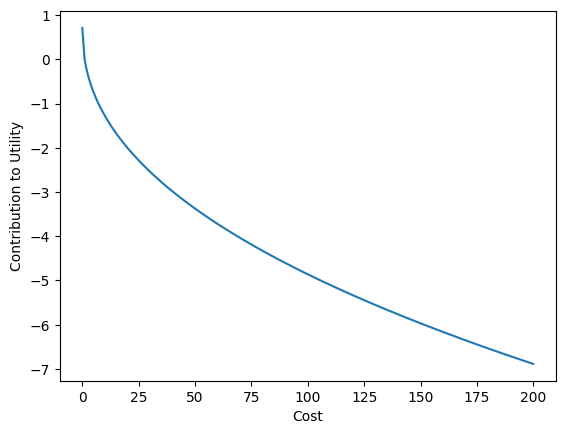

In [24]:
# Check impact on the utility
import numpy as np

lamda = results_3.get_beta_values()["lambda_boxcox"]
xx = np.linspace(0, 200, 201)
yy = (xx**(lamda) - 1) / (lamda) * results_3.get_beta_values()["beta_cost"]

plt.plot(xx, yy)
plt.xlabel("Cost")
plt.ylabel("Contribution to Utility")

plt.show()

In [27]:
compile_estimation_results({"Model pref (#2a)": results_2a, "Model #3" : results_3})

(                               Model pref (#2a)         Model #3
 Number of estimated parameters               11               12
 Sample size                                5000             5000
 Final log likelihood               -4375.986589     -4378.910543
 Akaike Information Criterion        8773.973177      8781.821086
 Bayesian Information Criterion      8845.662302      8860.027405
 asc_cycling (t-test)               -4.16  (-20)     -4.22  (-19)
 asc_cycling_female (t-test)     -0.805  (-4.08)  -0.807  (-4.09)
 asc_driving (t-test)             -1.92  (-13.8)   -2.35  (-10.5)
 asc_driving_female (t-test)     0.0792  (0.849)   0.077  (0.829)
 asc_pt (t-test)                  -2.41  (-17.2)   -2.51  (-17.2)
 asc_pt_female (t-test)            0.189  (1.93)    0.186  (1.89)
 beta_cost (t-test)              -0.146  (-9.97)  -0.317  (-4.41)
 beta_time_cycling (t-test)        -5.4  (-11.8)   -5.67  (-11.6)
 beta_time_driving (t-test)       -5.68  (-15.2)   -5.49  (-14.7)
 beta_time

We see that the log-likelihood as well as the AIC and BIC are higher with the new model, which means the model fit less good the data. Our assumption that a non-linear transformation in the form of a BoxCox would improve the model seems wrong.

---

I stopped here :)

We can perform a likelihood ratio test here, as the linear restriction that allows us to go back to our `model_pref` is $\lambda = 1$

In [25]:
results_3.likelihood_ratio_test(results_pref)

BiogemeError: The unrestricted model (-4378.910543129992, 12) has a lower log likelihood than the restricted one (-4375.986588546752, 11)